# Sample datasets (for Comic Relief)

Train classifier to distinguish Red Nose Day from Sport Relief

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
import zipfile

In [3]:
# So we don't run out of memory on resnet50
bs=16

## Download data into our notebook

In [ ]:
dataset = "https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/downloads/hot-dog-not-hot-dog.zip"

In [6]:
path = Path('/home/ec2-user/SageMaker/data-hot-dog-not-hot-dog/'); path

PosixPath('/home/ec2-user/SageMaker/data-hot-dog-not-hot-dog')

In [ ]:
zip_ref = zipfile.ZipFile('/home/ec2-user/SageMaker/data-hot-dog-not-hot-dog.zip', 'r')
zip_ref.extractall(path)
zip_ref.close()

In [7]:
tfms = get_transforms()
img_size=400
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=img_size, bs=bs).normalize(imagenet_stats)

In [ ]:
doc(ImageDataBunch.from_folder)

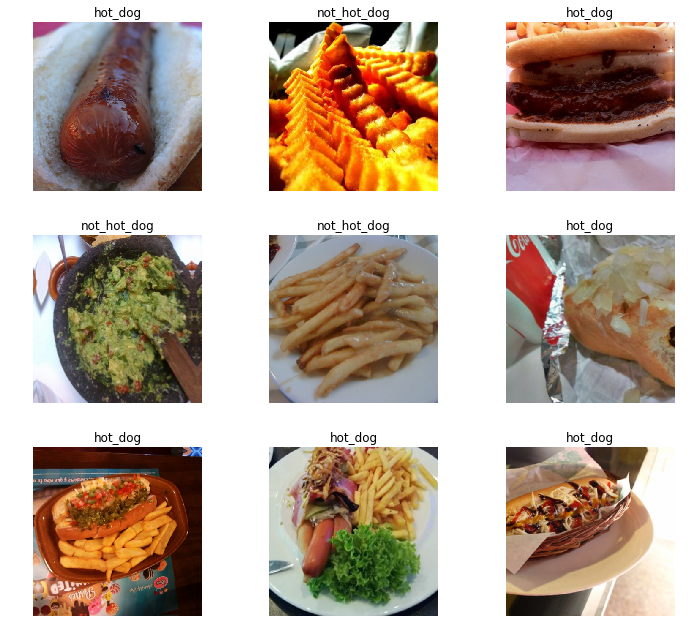

In [8]:
data.show_batch(rows=3, figsize=(10,9))

In [22]:
data.classes, data.c, data

(['hot_dog', 'not_hot_dog'], 2, ImageDataBunch;
 
 Train: LabelList (498 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 hot_dog,hot_dog,hot_dog,hot_dog,hot_dog
 Path: /home/ec2-user/SageMaker/data-hot-dog-not-hot-dog;
 
 Valid: LabelList (500 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 hot_dog,hot_dog,hot_dog,hot_dog,hot_dog
 Path: /home/ec2-user/SageMaker/data-hot-dog-not-hot-dog;
 
 Test: None)

## Transfer learning with resnet

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [38]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.536815,0.365125,0.866000,00:13
1,0.413616,0.299692,0.890000,00:14
2,0.362067,0.269863,0.894000,00:13
3,0.293872,0.252608,0.898000,00:13
4,0.228137,0.255528,0.896000,00:13


In [ ]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.077485,0.225342,0.934000,00:48
1,0.057217,0.244894,0.932000,00:49
2,0.059905,0.241483,0.930000,00:49
3,0.055919,0.243064,0.934000,00:49
4,0.045588,0.262249,0.922000,00:49
5,0.038723,0.256459,0.922000,00:49
6,0.039686,0.224939,0.928000,00:50
7,0.026164,0.232789,0.926000,00:49
8,0.042625,0.242348,0.924000,00:49
9,0.038659,0.249337,0.924000,00:49


In [20]:
learn.save('hotdog-stage-1') # saving the weights

In [ ]:
learn.load('hotdog-stage-1')

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

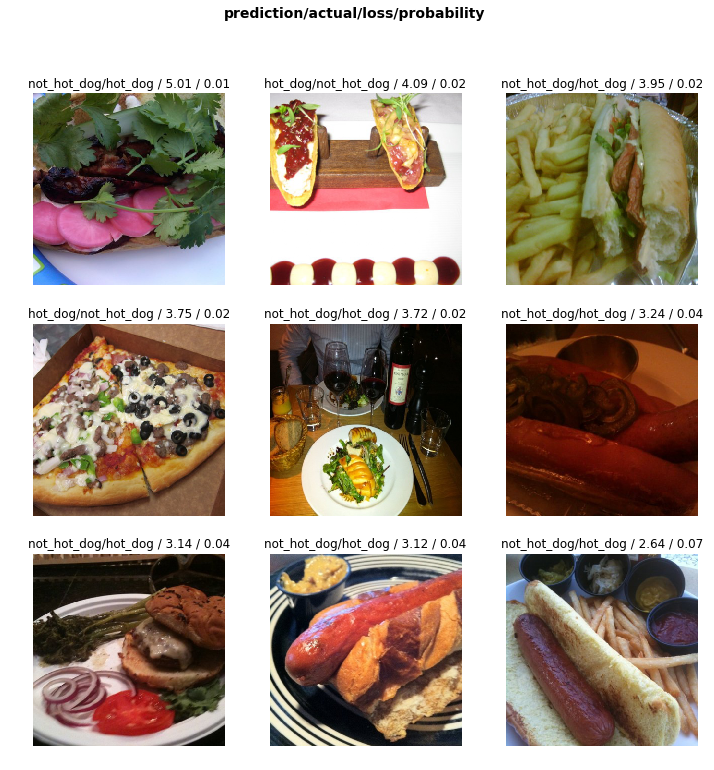

In [15]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=False)

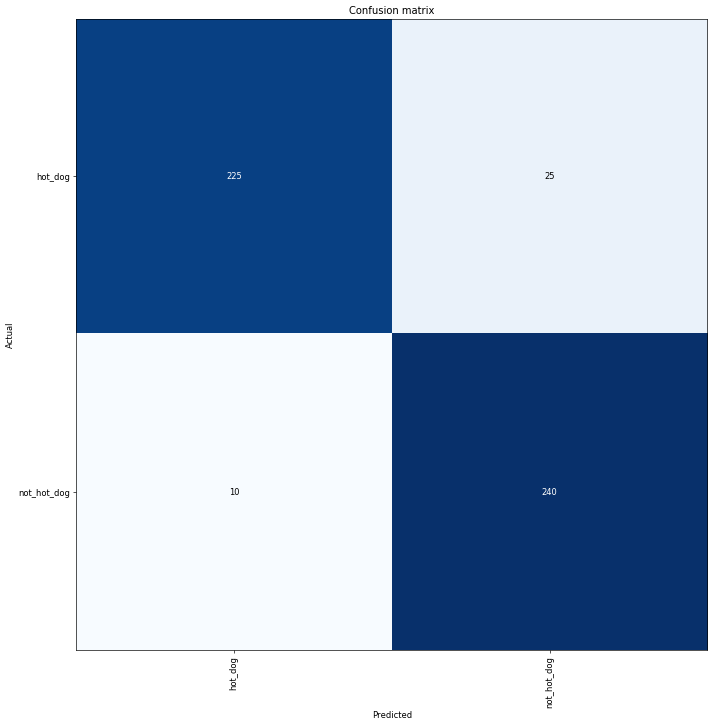

In [64]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Running model inference

This will create a file `export.pkl` in our data folder with a full export of the model

In [52]:
learn.export()

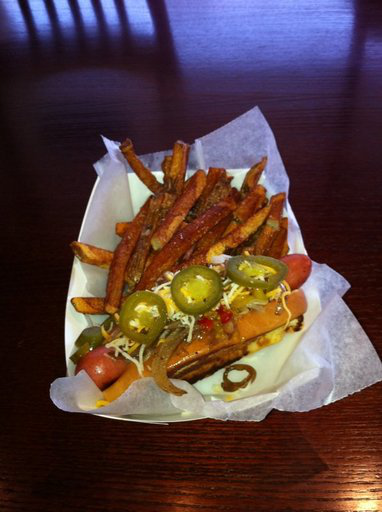

In [57]:
img = open_image(path/'valid/hot_dog'/'133012.jpg'); img

In [ ]:
learn = load_learner(path)

In [59]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category hot_dog

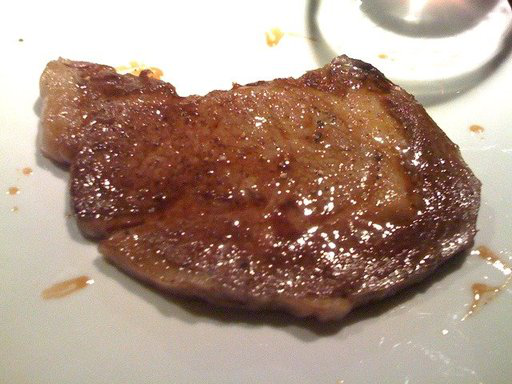

In [60]:
img2 = open_image(path/'valid/not_hot_dog'/'13023.jpg'); img2

In [62]:
pred_class,pred_idx,outputs = learn.predict(img2)
pred_class,pred_idx,outputs

(Category not_hot_dog, tensor(1), tensor([9.3855e-05, 9.9991e-01]))

## Exporting model to run in Lambda

Following tutorial from https://course.fast.ai/deployment_aws_lambda.html

First, we need to export model to `TorchScript` format and store in S3

In [63]:
import os
import io
import tarfile
import PIL
import boto3

In [70]:
save_texts(path/'models/classes.txt', data.classes)

In [68]:
trace_input = torch.ones(1,3,img_size,img_size).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='cr_jit.pth'
output_path = str(path/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

In [71]:
tar_file=path/'models/model.tar.gz'
classes_file='classes.txt'
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path/f'models/{model_file}', arcname=model_file)
    f.add(path/f'models/{classes_file}', arcname=classes_file)

In [72]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), 'fastai-model', 'hotdog/model.tar.gz')